In [1]:
%load_ext autoreload
%autoreload 2



import os
import tensorflow as tf
from tensorflow.keras import layers
assert tf.__version__.startswith('2')

from mediapipe_model_maker import object_detector
from mediapipe_model_maker import quantization
from mediapipe_model_maker.python.vision.object_detector import preprocessor
import matplotlib.pyplot as plt
from mediapipe_model_maker.python.vision.object_detector import model_spec

from mediapipe_model_maker.python.core.tasks import classifier
from mediapipe_model_maker.python.core.utils import model_util
from mediapipe_model_maker.python.core.utils import quantization
from mediapipe_model_maker.python.vision.object_detector import dataset as ds
from mediapipe_model_maker.python.vision.object_detector import hyperparameters as hp
from mediapipe_model_maker.python.vision.object_detector import model as model_lib
from mediapipe_model_maker.python.vision.object_detector import model_options as model_opt
from mediapipe_model_maker.python.vision.object_detector import model_spec as ms
from mediapipe_model_maker.python.vision.object_detector import object_detector_options
from mediapipe_model_maker.python.vision.object_detector import preprocessor
from mediapipe.tasks.python.metadata.metadata_writers import metadata_info
from mediapipe.tasks.python.metadata.metadata_writers import metadata_writer
from mediapipe.tasks.python.metadata.metadata_writers import object_detector as object_detector_writer
from official.vision.evaluation import coco_evaluator

2024-09-25 17:08:55.103856: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 17:08:55.125904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 17:08:55.125934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 17:08:55.126723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 17:08:55.130611: I tensorflow/core/platform/cpu_feature_guar

In [19]:

train_dataset_path="/media/sombrali/HDD1/3d_object_detection/mediapipe/dataset/v2/concated_coco_v2/train"
train_data = object_detector.Dataset.from_coco_folder(train_dataset_path, cache_dir="/tmp/od_data/v2_concated_fp/train")

# for data in train_data._dataset:
#     image = data['image']
#     plt.imshow(image)
#     plt.show()
#     break
hparams = object_detector.HParams(batch_size=32, 
                                    learning_rate = 0.01, 
                                    cosine_decay_epochs = 30, 
                                    epochs = 32, 
                                    export_dir=f'weights/test')

spec = object_detector.SupportedModels.MOBILENET_V2_I320
options = object_detector.ObjectDetectorOptions(
    supported_model=spec,
    hparams=hparams
)

spec = ms.SupportedModels.get(options.supported_model)
_preprocessor = preprocessor.Preprocessor(spec)
train_dataset = train_data.gen_tf_dataset(
    batch_size=32,
    is_training=True,
    shuffle=True,
    preprocess=_preprocessor,
)
iterator = iter(train_dataset)


(32, 832, 832, 3) <dtype: 'uint8'>
(32, 832, 832, 3) <dtype: 'uint8'>


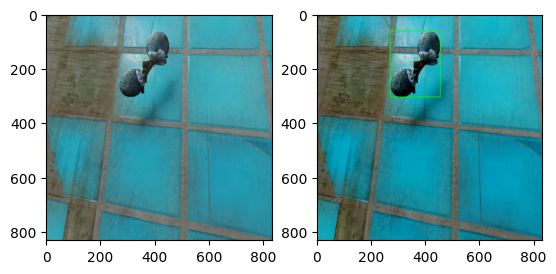

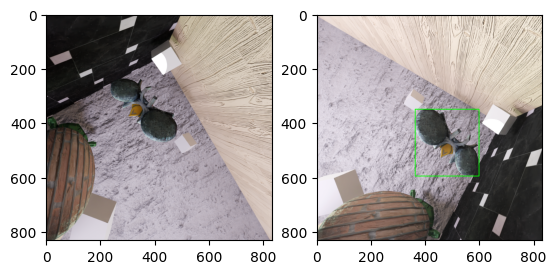

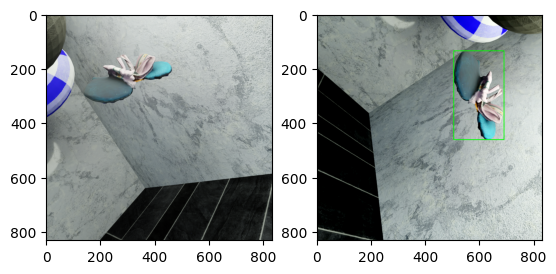

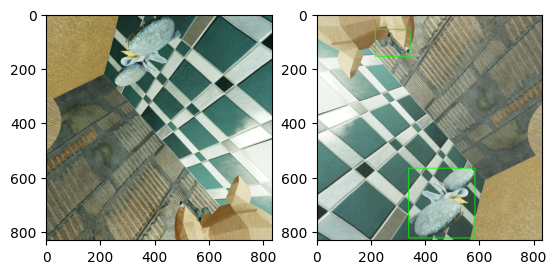

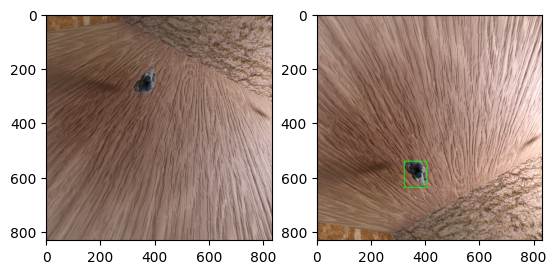

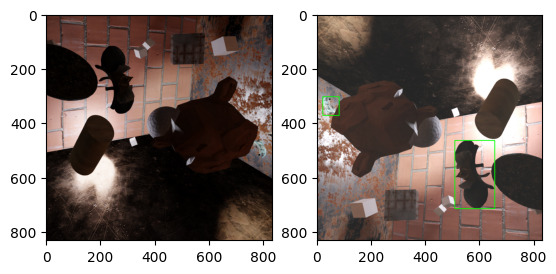

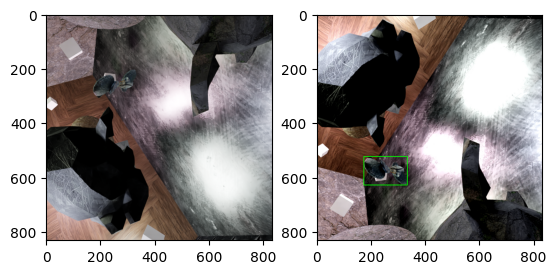

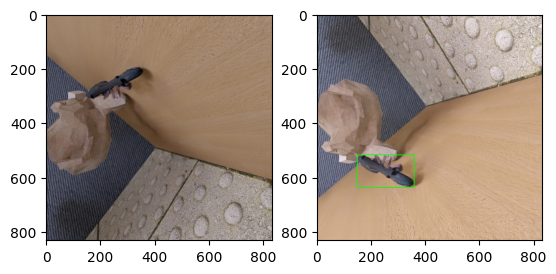

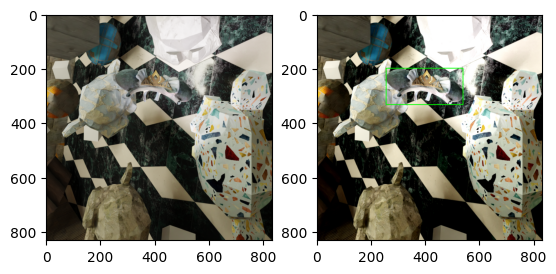

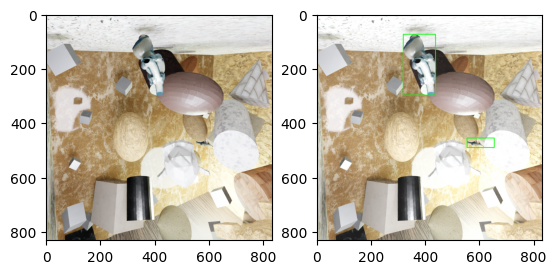

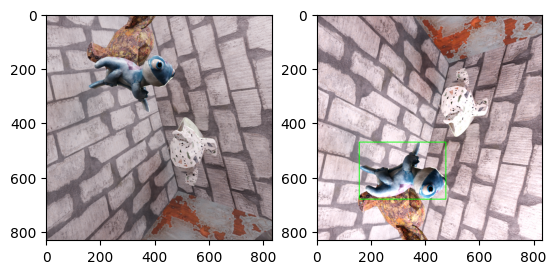

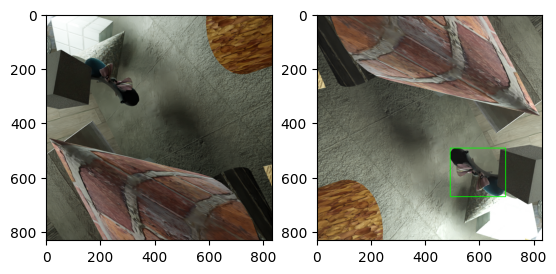

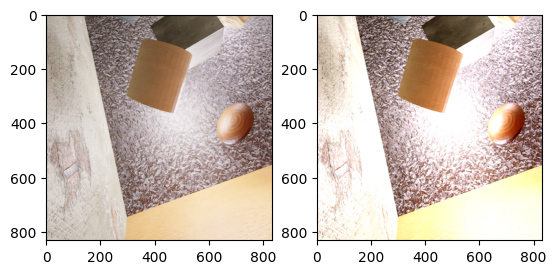

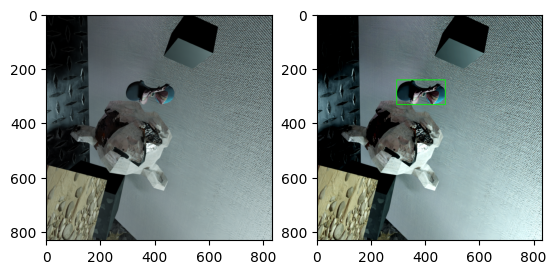

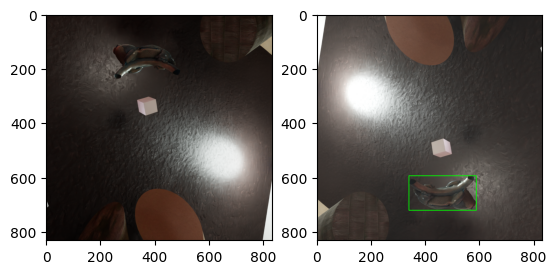

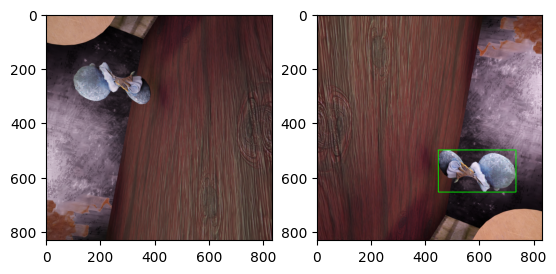

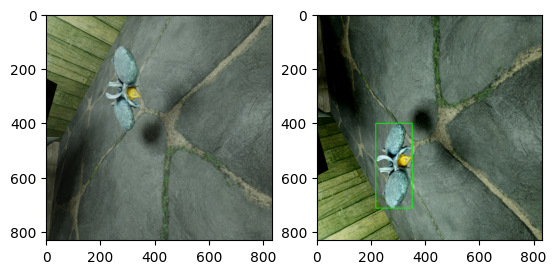

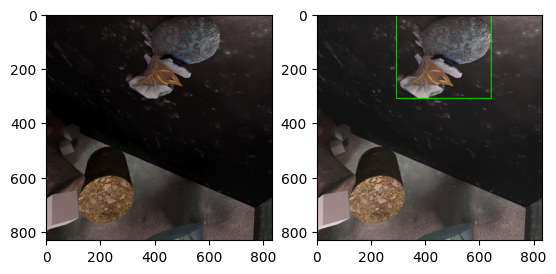

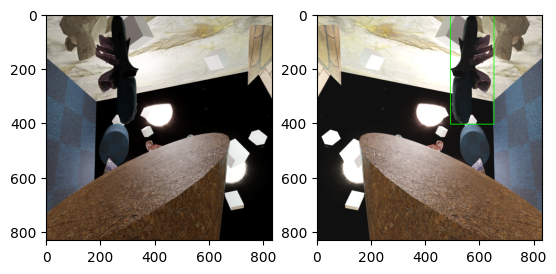

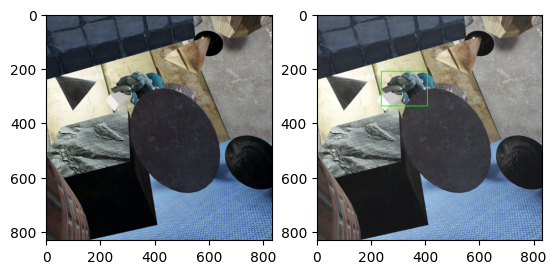

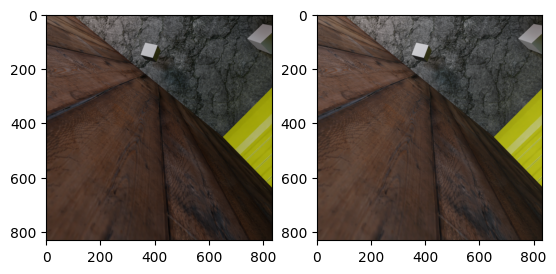

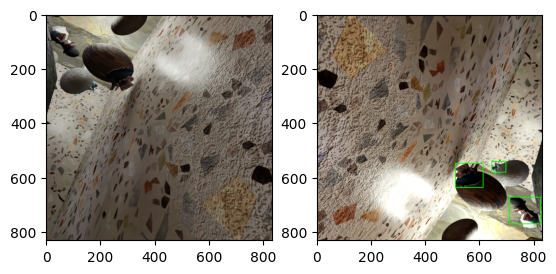

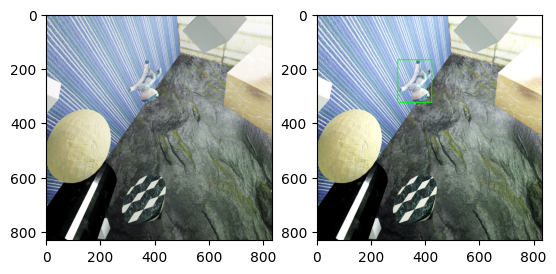

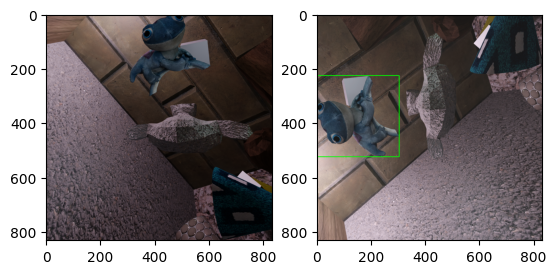

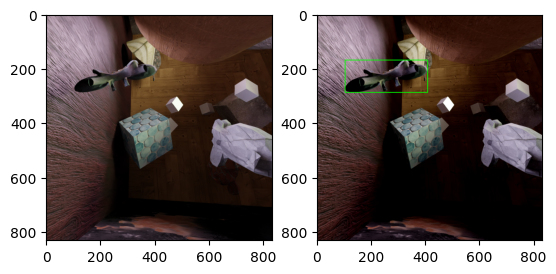

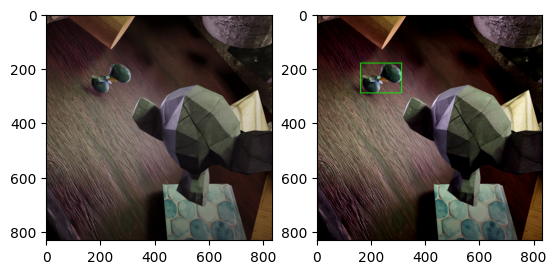

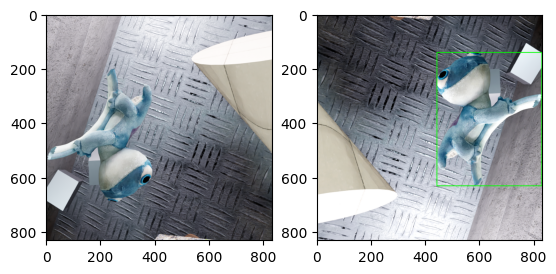

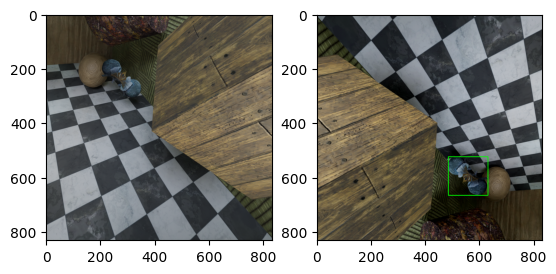

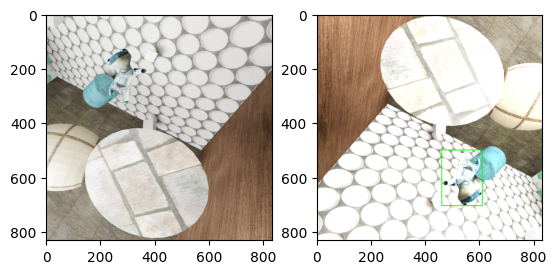

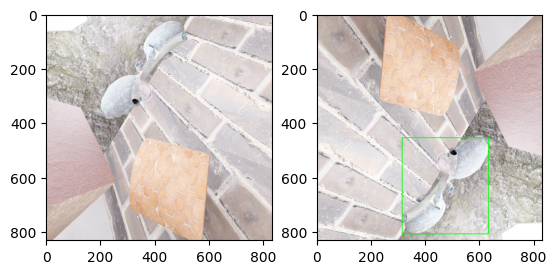

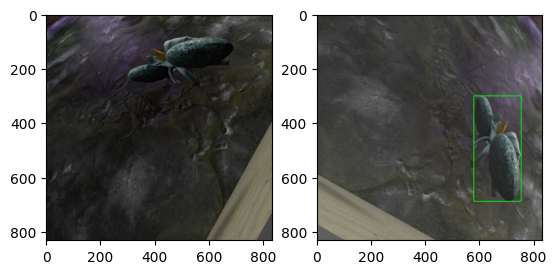

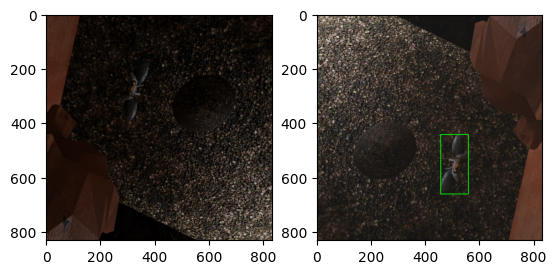

In [20]:
%matplotlib inline
import numpy as np
import cv2
for data in iterator:

    print(data[0].shape, data[0].dtype)
    print(data[1].shape, data[1].dtype)
    batch_boxes = data[2]['groundtruths']['boxes']

    for i in range(len(data[0])):
        raw_image = np.array(data[0][i])
        augmented_image =  np.array(data[1][i])
        boxes = batch_boxes[i]
        for box in boxes:
            y1, x1, y2, x2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # cv2.rectangle(raw_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.rectangle(augmented_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # show two images
        plt.subplot(1, 2, 1)
        plt.imshow(raw_image)
        plt.subplot(1, 2, 2)
        plt.imshow(augmented_image)
        plt.show()
    break


In [34]:
data[2]['groundtruths']['boxes']

<tf.Tensor: shape=(32, 100, 4), dtype=float32, numpy=
array([[[  0.     ,   0.     ,   0.     ,   0.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        ...,
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ]],

       [[182.     , 273.     , 456.     , 455.     ],
        [531.     , 197.     , 705.     , 288.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        ...,
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ]],

       [[194.     , 156.     , 311.     , 364.     ],
        [277.     , 698.     , 363.     , 832.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        ...,
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.    

In [35]:
 data[2]['groundtruths']['classes']

<tf.Tensor: shape=(32, 100), dtype=int64, numpy=
array([[ 0, -1, -1, ..., -1, -1, -1],
       [ 2,  1, -1, ..., -1, -1, -1],
       [ 2,  1, -1, ..., -1, -1, -1],
       ...,
       [ 1, -1, -1, ..., -1, -1, -1],
       [ 3, -1, -1, ..., -1, -1, -1],
       [ 2, -1, -1, ..., -1, -1, -1]])>